In [11]:

# import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# defines

# file name defines
MAZE_FILE_NAME = '../../../images/Maze_2.png'
ROBOT_FILE_NAME = '../../../images/Robot_2.png'
IMAGE_LADYBUG_FILE_NAME = '../../../images/Ladybug_small.png'
MAP_FILE_NAME = '../../../images/MapBuilt.txt'

# Task 3.1 - General
BGR_B = (255, 0, 0)
BGR_G = (0, 255, 0)
BGR_R = (0, 0, 255)
BGR_CYAN = (248, 242, 123)
BGR_MAGENTA = (246, 27, 242)
LINE_THICKNESS = 4

# Task 3.3
LEFT_LOWER = 0
LEFT_UPPER = 337.5
RIGHT_LOWER = 1012.5
RIGHT_UPPER = 1350
TOP_LOWER = 0
TOP_UPPER = 375
BOTTOM_LOWER = 375
BOTTOM_UPPER = 750
TL = [0, 0]
TR = [900, 0]
BL = [0, 500]
BR = [900, 500]
TALL_RES = 500
WIDE_RES = 900

# TASK 3.4
ROWS = 5
COLS = 9
GRID_PIXELS = 100
WALL_PIXELS = 10
MID_BUFF = 45
END_BUFF = 95
WALL_THRESHOLD = 75

# TASK 3.7
BORDER_H = " --- --- --- --- --- --- --- --- --- "


# GENERAL FUNCTION

def get_transformed_maze_hsv(path):
    maze_hsv = read_image_hsv(path)
    magenta_contours, cyan_contour = get_cornerstone_contours(maze_hsv)
    return perspective_transform(maze_hsv, magenta_contours, cyan_contour)


# TASK 3.1

def read_image_rgb(path):
    image_bgr = cv2.imread(path) 
    if image_bgr is None:
        raise FileNotFoundError('Could not read in: ' + path)
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

def read_image_hsv(path):
    image_hsv = cv2.imread(path)
    if image_hsv is None:
        raise FileNotFoundError('Could not read in: ' + path)
    return cv2.cvtColor(image_hsv, cv2.COLOR_BGR2HSV)

def read_image_gray(path):
    image_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image_gray is None:
        raise FileNotFoundError('Could not read in: ' + path)
    return image_gray


# TASK 3.2

def get_cornerstone_contours(maze_hsv):
    # magenta
    magenta_lower = np.array([148, 175, 200])
    magenta_upper = np.array([152, 255, 255])
    magenta_mask = cv2.inRange(maze_hsv, magenta_lower, magenta_upper)
    magenta_masked = cv2.bitwise_and(maze_hsv, maze_hsv, mask=magenta_mask)
    magenta_edges = cv2.Canny(magenta_masked, threshold1=150, threshold2=200, apertureSize=5)
    _, magenta_contours, _ = cv2.findContours(magenta_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    magenta_contours = sorted(magenta_contours, reverse=True, key=lambda x : cv2.contourArea(x))
    magenta_contours = magenta_contours[:3]

    # cyan
    cyan_lower = np.array([89, 10, 200])
    cyan_upper = np.array([93, 255, 255])
    cyan_mask = cv2.inRange(maze_hsv, cyan_lower, cyan_upper)
    cyan_masked = cv2.bitwise_and(maze_hsv, maze_hsv, mask=cyan_mask)
    cyan_edges = cv2.Canny(cyan_masked, threshold1=150, threshold2=200, apertureSize=5)
    _, cyan_contours, _ = cv2.findContours(cyan_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cyan_contours = sorted(cyan_contours, reverse=True, key=lambda x : cv2.contourArea(x))
    cyan_contour = cyan_contours[0]
    
    return magenta_contours, cyan_contour

def draw_cornerstones(maze_bgr, magenta_contours, cyan_contour):
    # draw magenta corners
    cv2.drawContours(maze_bgr, magenta_contours, -1, BGR_CYAN, LINE_THICKNESS)
    # draw cyan corners
    cv2.drawContours(maze_bgr, cyan_contour, 0, BGR_MAGENTA, LINE_THICKNESS)

    return maze_bgr


# TASK 3.3

def perspective_transform(maze_img, magenta_contours, cyan_contour):
    magenta_corners = {}
    cyan_corners = []

    for cont in magenta_contours:
        corner = create_corner(cont, 'magenta')
        magenta_corners[str(corner.get('id'))] = corner

    cyan_corners.append(create_corner(cyan_contour, 'cyan'))

    point_original = np.float32(sort_corners(cyan_corners[0], magenta_corners))
    point_transformed = np.float32([TL, TR, BL, BR])

    H = cv2.getPerspectiveTransform(point_original, point_transformed)
    transformed = cv2.warpPerspective(maze_img, H, (WIDE_RES, TALL_RES))

    return transformed, H

def create_corner(contour, colour):
    m = cv2.moments(contour)
    cx = m['m10'] // (m['m00'] or 0.00000001)
    cy = m['m01'] // (m['m00'] or 0.00000001)
    return {
        'colour': colour,
        'x' : cx,
        'y' : cy,
        'id' : left_or_right(cx) + top_or_bottom(cy),
    }

def left_or_right(x):
    # left
    if (x >= LEFT_LOWER and x <= LEFT_UPPER):
        return 0
    # right
    elif (x >= RIGHT_LOWER and x <= RIGHT_UPPER):
        return 1

def top_or_bottom(y):
    # top
    if (y >= TOP_LOWER and y <= TOP_UPPER):
        return 0
    # bottom
    elif (y > BOTTOM_LOWER and y <= BOTTOM_UPPER):
        return 2

def sort_corners(cyan, magenta):
    # ordered corners
    corner_1 = None
    corner_2 = None
    corner_3 = None
    # ordering depending on where the cyan corner is
    if (cyan.get('id') == 0):
        corner_1 = magenta.get('1')
        corner_2 = magenta.get('2')
        corner_3 = magenta.get('3')
    elif (cyan.get('id') == 1):
        corner_1 = magenta.get('3')
        corner_2 = magenta.get('0')
        corner_3 = magenta.get('2')
    elif (cyan.get('id') == 2):
        corner_1 = magenta.get('0')
        corner_2 = magenta.get('3')
        corner_3 = magenta.get('1')
    elif (cyan.get('id') == 3):
        corner_1 = magenta.get('2')
        corner_2 = magenta.get('1')
        corner_3 = magenta.get('0')
    
    # add ordered corners to the list
    ordered = [[cyan.get('x'), cyan.get('y')]]
    ordered.append([corner_1.get('x'), corner_1.get('y')])
    ordered.append([corner_2.get('x'), corner_2.get('y')])
    ordered.append([corner_3.get('x'), corner_3.get('y')])
    return ordered


# TASK 3.4

def get_walls(maze_hsv):
    # masking
    wall_lower = np.array([16, 85, 215])
    wall_upper = np.array([20, 115, 245])
    wall_mask = cv2.inRange(maze_hsv, wall_lower, wall_upper)
    wall_masked = cv2.bitwise_and(maze_hsv, maze_hsv, mask=wall_mask)
    _, _, wall_gray = cv2.split(wall_masked)

    # vertical walls
    vertical = np.zeros((ROWS, COLS - 1), dtype=bool)
    for row in range(ROWS):
        y_start = row * GRID_PIXELS + MID_BUFF
        y_end =  y_start + WALL_PIXELS
        for col in range(COLS - 1):        
            x_start = col * GRID_PIXELS + END_BUFF
            x_end = x_start + WALL_PIXELS
            sample = wall_gray[y_start:y_end, x_start:x_end]
            if (np.mean(sample) > WALL_THRESHOLD):
                vertical[row][col] = True

    # horizontal walls
    horizontal = np.zeros((ROWS - 1, COLS), dtype=bool)
    for row in range(ROWS - 1):
        y_start = row * GRID_PIXELS + END_BUFF
        y_end =  y_start + WALL_PIXELS
        for col in range(COLS):        
            x_start = col * GRID_PIXELS + MID_BUFF
            x_end = x_start + WALL_PIXELS
            sample = wall_gray[y_start:y_end, x_start:x_end]
            if (np.mean(sample) > WALL_THRESHOLD):
                horizontal[row][col] = True

    return (vertical, horizontal)

def draw_walls(maze_hsv, maze_bgr):
    # masking
    wall_lower = np.array([16, 85, 215])
    wall_upper = np.array([20, 115, 245])
    wall_mask = cv2.inRange(maze_hsv, wall_lower, wall_upper)
    wall_masked = cv2.bitwise_and(maze_hsv, maze_hsv, mask=wall_mask)
    _, _, wall_gray = cv2.split(wall_masked)

    # vertical walls
    for row in range(ROWS):
        y_start = row * GRID_PIXELS + MID_BUFF
        y_end =  y_start + WALL_PIXELS
        for col in range(COLS - 1):        
            x_start = col * GRID_PIXELS + END_BUFF
            x_end = x_start + WALL_PIXELS
            sample = wall_gray[y_start:y_end, x_start:x_end]
            if (np.mean(sample) > WALL_THRESHOLD):
                x1 = col * GRID_PIXELS + GRID_PIXELS
                y1 = row * GRID_PIXELS
                x2 = x1
                y2 = y1 + GRID_PIXELS
                cv2.line(maze_bgr, (x1, y1), (x2, y2), BGR_B, LINE_THICKNESS)

    # horizontal walls
    for row in range(ROWS - 1):
        y_start = row * GRID_PIXELS + END_BUFF
        y_end =  y_start + WALL_PIXELS
        for col in range(COLS):        
            x_start = col * GRID_PIXELS + MID_BUFF
            x_end = x_start + WALL_PIXELS
            sample = wall_gray[y_start:y_end, x_start:x_end]
            if (np.mean(sample) > WALL_THRESHOLD):
                x1 = col * GRID_PIXELS
                y1 = row * GRID_PIXELS + GRID_PIXELS
                x2 = x1 + GRID_PIXELS
                y2 = y1
                cv2.line(maze_bgr, (x1, y1), (x2, y2), BGR_B, LINE_THICKNESS)

    return maze_bgr


# TASK 3.5

def get_robot_coordinates(maze_hsv):
    # mask
    robot_lower = np.array([35, 50, 50])
    robot_upper = np.array([85, 250, 250])
    robot_mask = cv2.inRange(maze_hsv, robot_lower, robot_upper)
    robot_masked = cv2.bitwise_and(maze_hsv, maze_hsv, mask=robot_mask)
    robot_edges = cv2.Canny(robot_masked, threshold1=150, threshold2=175, apertureSize=5)
    _, robot_contours, _ = cv2.findContours(robot_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sum_m00 = 0 # area
    sum_m10 = 0 # area * x
    sum_m01 = 0 # area * y

    for contour in robot_contours:
        M = cv2.moments(contour)
        sum_m00 += M['m00']
        sum_m10 += M['m10']
        sum_m01 += M['m01']

    robot_x = sum_m10 // (sum_m00 or 0.00000001)
    robot_y = sum_m01 // (sum_m00 or 0.00000001)

    return robot_y // GRID_PIXELS, robot_x // GRID_PIXELS

def get_robot_heading(robot_img, H):
    dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
    parameters = cv2.aruco.DetectorParameters_create()
    marker_corners, marker_ids, rejected = cv2.aruco.detectMarkers(robot_img, dictionary, parameters=parameters)

    # get marker points
    head = None
    tail = None
    for i, marker_id in enumerate(marker_ids):
        if marker_id == 1:
            head = marker_corners[i][0][0]
            tail = marker_corners[i][0][2]

    if (head is None or tail is None):
        print("ERROR: ARUCO MARKER NOT FOUND")
        print(marker_corners)
        print(marker_ids)
        print(rejected)

    heading_angle = line_angle_4th_quadrant(head, tail)
    offset = np.rad2deg(-np.arctan2(H[1][0], H[0][0]))
    angle = int(heading_angle + offset) % 360

    heading = 'o'
    if (angle >= 0 and angle <= 30) or (angle >= 330 and angle <= 360):
        heading = '>'
    elif angle > 60 and angle <= 120:
        heading = '^'
    elif angle >= 150 and angle <= 210:
        heading = '<'
    elif angle >= 240 and angle <= 300:
        heading = 'v'

    return heading

def draw_robot(maze_bgr, robot_coordinates, robot_heading):
    cx = robot_coordinates[1] * GRID_PIXELS + (GRID_PIXELS // 2)
    cy = robot_coordinates[0] * GRID_PIXELS + (GRID_PIXELS // 2)
    radius = GRID_PIXELS // 4
    cv2.circle(maze_bgr, (cx, cy), radius, BGR_R, LINE_THICKNESS)

    location = (cx, cy)
    if robot_heading == '>':
        location = (cx - 10, cy + 10)
    elif robot_heading == '^':
        location = (cx - 11, cy + 9)
    elif robot_heading == '<':
        location = (cx - 15, cy + 10)
    elif robot_heading == 'v':
        location = (cx - 8, cy + 8)

    cv2.putText(maze_bgr, robot_heading, location, cv2.FONT_HERSHEY_SIMPLEX, 1, BGR_R, 2, cv2.LINE_AA)
    return maze_bgr

def line_angle_4th_quadrant(head, tail):
    diff_x = head[0] - tail[0]
    diff_y = head[1] - tail[1]
    angle = np.arctan2(-diff_y, diff_x)
    return np.rad2deg(angle % (np.pi * 2))


# TASK 3.6

def get_target_coordinates(maze_hsv, bug_gray):
    _, _, maze_gray = cv2.split(maze_hsv)
    surf = cv2.xfeatures2d.SURF_create()
    kp_maze, des_maze = surf.detectAndCompute(maze_gray, None) # query
    kp_bug, des_bug = surf.detectAndCompute(bug_gray, None) # train
    bfm = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bfm.match(des_maze, des_bug)
    matches = sorted(matches, key=lambda x : x.distance)
    match_threshold = matches[0].distance * 2
    count = np.zeros((ROWS, COLS), dtype=np.int8)

    for match in matches:
        if match.distance < match_threshold:
            x, y = kp_maze[match.queryIdx].pt
            count[int(y // GRID_PIXELS)][int(x // GRID_PIXELS)] += 1

    return np.unravel_index(np.argmax(count, axis=None), count.shape)

# draw destination

def draw_target(maze_bgr, target_coordinates):
    cx = target_coordinates[1] * GRID_PIXELS + (GRID_PIXELS // 2)
    cy = target_coordinates[0] * GRID_PIXELS + (GRID_PIXELS // 2)
    radius = GRID_PIXELS // 4
    cv2.circle(maze_bgr, (cx, cy), radius, BGR_G, LINE_THICKNESS)

    x1 = cx - int(radius * 0.5 * np.cos(45))
    x2 = cx + int(radius * 0.5 * np.cos(45))
    y1 = cy - int(radius * 0.5 * np.sin(45))
    y2 = cy + int(radius * 0.5 * np.sin(45))
    cv2.line(maze_bgr, (x1, y1), (x2, y2), BGR_G, LINE_THICKNESS)
    cv2.line(maze_bgr, (x1, y2), (x2, y1), BGR_G, LINE_THICKNESS)

    return maze_bgr


# TASK 3.7

def get_map_string(walls):
    horizontal = walls[1]
    # adding horizontal walls
    horizontal_output = [BORDER_H] # add border
    for row in range(ROWS - 1):
        line = ' ' # padding
        for col in range(COLS):
            if (horizontal[row][col]):
                line += '--- '
            else:
                line += '    '
        horizontal_output.append(line)

    # adding vertical walls
    vertical = walls[0]
    vertical_output = []
    for row in range(ROWS):
        line = '|' # border
        for col in range(COLS - 1):
            line += '    '
            if (vertical[row][col]):
                line += '|'
            else:
                line += ' '
        # check content of last col
        line += '    '
        line += '|' # border
        vertical_output.append(line)

    # creating the map string
    map_string = ''
    for i in range(ROWS):
        map_string += horizontal_output[i] + '\n'
        map_string += vertical_output[i] + '\n'
    map_string += BORDER_H

    return map_string

In [13]:
# runCVLocaliser
if __name__ == '__main__':
    mazeFileName = '../../../images/Maze_2.png'
    robotFileName = '../../../images/Robot_2.png'
    maze_transformed_hsv, H = get_transformed_maze_hsv(mazeFileName)
    epuck_position = get_robot_coordinates(maze_transformed_hsv)
    robot_gray = read_image_gray(robotFileName)
    epuck_direction = get_robot_heading(robot_gray, H) # TODO: currently returns as a char - ^ v < >
    print(epuck_position, epuck_direction)

(2.0, 4.0) <


In [14]:
# runCVWaypointer
if __name__ == '__main__':
    mazeFileName = '../../../images/Maze_2.png'
    destinationFileName = '../../../images/Ladybug_small.png'
    maze_transformed_hsv, _ = get_transformed_maze_hsv(mazeFileName)
    bug_gray = read_image_gray(destinationFileName)
    destination = get_target_coordinates(maze_transformed_hsv, bug_gray)
    print(destination)

(2, 2)


In [15]:
# runCVMapper
if __name__ == '__main__':
    mazeFileName = '../../../images/Maze_2.png'
    maze_transformed_hsv, _ = get_transformed_maze_hsv(mazeFileName)
    walls = get_walls(maze_transformed_hsv)
    maze_map = list(get_map_string(walls))
    print(maze_map)

[' ', '-', '-', '-', ' ', '-', '-', '-', ' ', '-', '-', '-', ' ', '-', '-', '-', ' ', '-', '-', '-', ' ', '-', '-', '-', ' ', '-', '-', '-', ' ', '-', '-', '-', ' ', '-', '-', '-', ' ', '\n', '|', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '|', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '|', '\n', ' ', ' ', ' ', ' ', ' ', '-', '-', '-', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-', '-', '-', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '\n', '|', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '|', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '|', ' ', ' ', ' ', ' ', '|', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '|', '\n', ' ', '-', '-', '-', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '-', '-', '-', ' ', '-', '-', '-', ' ', ' ', ' ', ' ', ' ', 

## Test Perspective Transform

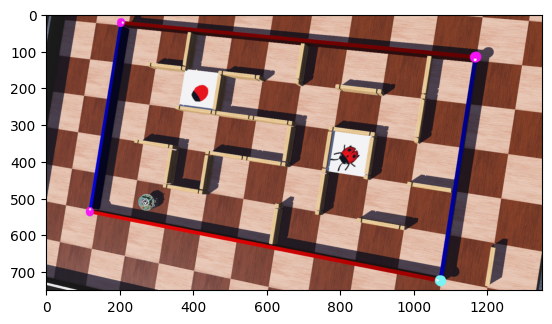

In [7]:
maze_transformed_hsv, H = get_transformed_maze_hsv(MAZE_FILE_NAME)

# display maze
maze_rgb = cv2.cvtColor(maze_transformed_hsv, cv2.COLOR_HSV2RGB)
plt.imshow(maze_rgb)
plt.show()